In [122]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve, auc)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap


In [123]:
# ===========================
# Load + Preprocess Data
# ===========================
with zipfile.ZipFile('creditcard.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

data = pd.read_csv('creditcard.csv')

# Scale Amount, drop Time
sc = StandardScaler()
data['Amount'] = sc.fit_transform(pd.DataFrame(data['Amount']))
data = data.drop(['Time'], axis=1)

# Drop duplicates
data = data.drop_duplicates()
print("Class distribution:\n", data['Class'].value_counts())

Class distribution:
 0    275190
1       473
Name: Class, dtype: int64


In [124]:
# ===========================
# Helper function for evaluation
# ===========================
def evaluate_models(X_train, X_test, y_train, y_test, title=""):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=500),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': lgb.LGBMClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
        'Balanced RF': BalancedRandomForestClassifier(),
        'EasyEnsemble': EasyEnsembleClassifier()
    }

    results = []

    # ROC & PR plots
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.title(f"ROC Curves ({title})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.subplot(1,2,2)
    plt.title(f"Precision-Recall Curves ({title})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        results.append([name, acc*100, prec, rec, f1, roc_auc])

        print(f"\n{name} ({title}) Results:")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.subplot(1,2,1)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

        # PR Curve
        pr, rc, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(rc, pr)
        plt.subplot(1,2,2)
        plt.plot(rc, pr, label=f"{name} (PR-AUC={pr_auc:.2f})")

    # Finalize ROC plot
    plt.subplot(1,2,1)
    plt.plot([0,1],[0,1],'k--')
    plt.legend()

    # Finalize PR plot
    plt.subplot(1,2,2)
    plt.legend()

    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','ROC-AUC'])
    print(f"\nFinal Results ({title}):\n", results_df)
    return results_df


Logistic Regression (Undersampling) Results:
Confusion Matrix:
 [[85  3]
 [ 9 93]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        88
           1       0.97      0.91      0.94       102

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.94      0.94      0.94       190


Decision Tree (Undersampling) Results:
Confusion Matrix:
 [[81  7]
 [ 7 95]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        88
           1       0.93      0.93      0.93       102

    accuracy                           0.93       190
   macro avg       0.93      0.93      0.93       190
weighted avg       0.93      0.93      0.93       190


Random Forest (Undersampling) Results:
Confusion Matrix:
 [[86  2]
 [ 8 94]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 


Balanced RF (Undersampling) Results:
Confusion Matrix:
 [[86  2]
 [ 9 93]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        88
           1       0.98      0.91      0.94       102

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.94      0.94      0.94       190


EasyEnsemble (Undersampling) Results:
Confusion Matrix:
 [[84  4]
 [ 8 94]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        88
           1       0.96      0.92      0.94       102

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.94      0.94      0.94       190



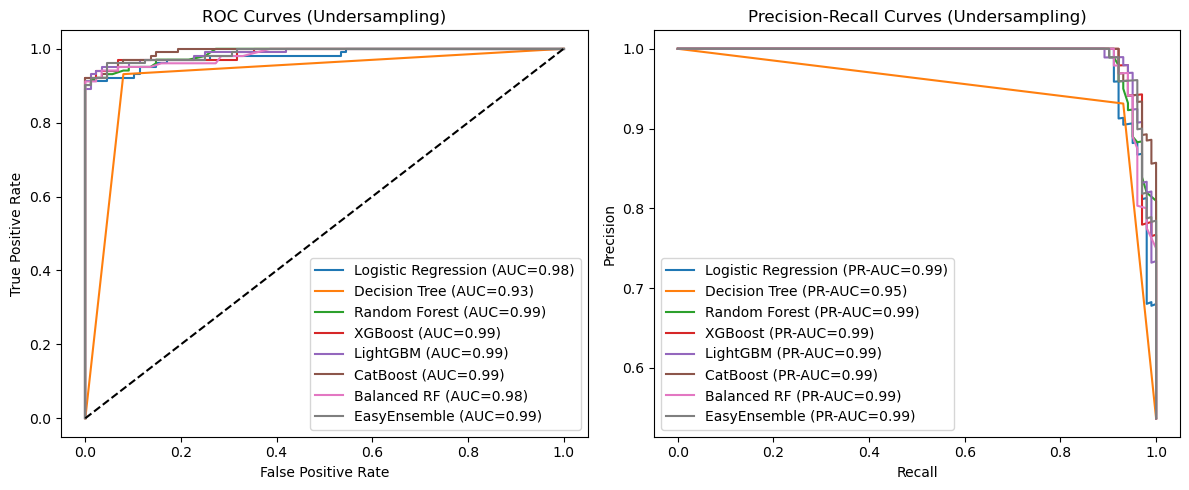


Final Results (Undersampling):
                  Model   Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  93.684211   0.968750  0.911765  0.939394  0.980058
1        Decision Tree  92.631579   0.931373  0.931373  0.931373  0.925914
2        Random Forest  94.736842   0.979167  0.921569  0.949495  0.987467
3              XGBoost  95.263158   0.979381  0.931373  0.954774  0.987857
4             LightGBM  95.789474   0.989583  0.931373  0.959596  0.988191
5             CatBoost  95.789474   1.000000  0.921569  0.959184  0.992424
6          Balanced RF  94.210526   0.978947  0.911765  0.944162  0.984514
7         EasyEnsemble  93.684211   0.959184  0.921569  0.940000  0.988191


In [125]:
# ===========================
# 1. Undersampling
# ===========================
normal = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]
normal_sample = normal.sample(n=len(fraud), random_state=42)
new_data = pd.concat([normal_sample, fraud], ignore_index=True)

X = new_data.drop('Class', axis=1)
y = new_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results_under = evaluate_models(X_train, X_test, y_train, y_test, title="Undersampling")


Logistic Regression (SMOTE Oversampling) Results:
Confusion Matrix:
 [[53664  1409]
 [ 4609 50394]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     55073
           1       0.97      0.92      0.94     55003

    accuracy                           0.95    110076
   macro avg       0.95      0.95      0.95    110076
weighted avg       0.95      0.95      0.95    110076


Decision Tree (SMOTE Oversampling) Results:
Confusion Matrix:
 [[54940   133]
 [   62 54941]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55073
           1       1.00      1.00      1.00     55003

    accuracy                           1.00    110076
   macro avg       1.00      1.00      1.00    110076
weighted avg       1.00      1.00      1.00    110076


Random Forest (SMOTE Oversampling) Results:
Confusion Matrix:
 [[55064     9]
 [    0 55003]]
              precision    recall  f1-score   support



Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 


Balanced RF (SMOTE Oversampling) Results:
Confusion Matrix:
 [[55065     8]
 [    0 55003]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55073
           1       1.00      1.00      1.00     55003

    accuracy                           1.00    110076
   macro avg       1.00      1.00      1.00    110076
weighted avg       1.00      1.00      1.00    110076


EasyEnsemble (SMOTE Oversampling) Results:
Confusion Matrix:
 [[53654  1419]
 [ 2839 52164]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     55073
           1       0.97      0.95      0.96     55003

    accuracy                           0.96    110076
   macro avg       0.96      0.96      0.96    110076
weighted avg       0.96      0.96      0.96    110076



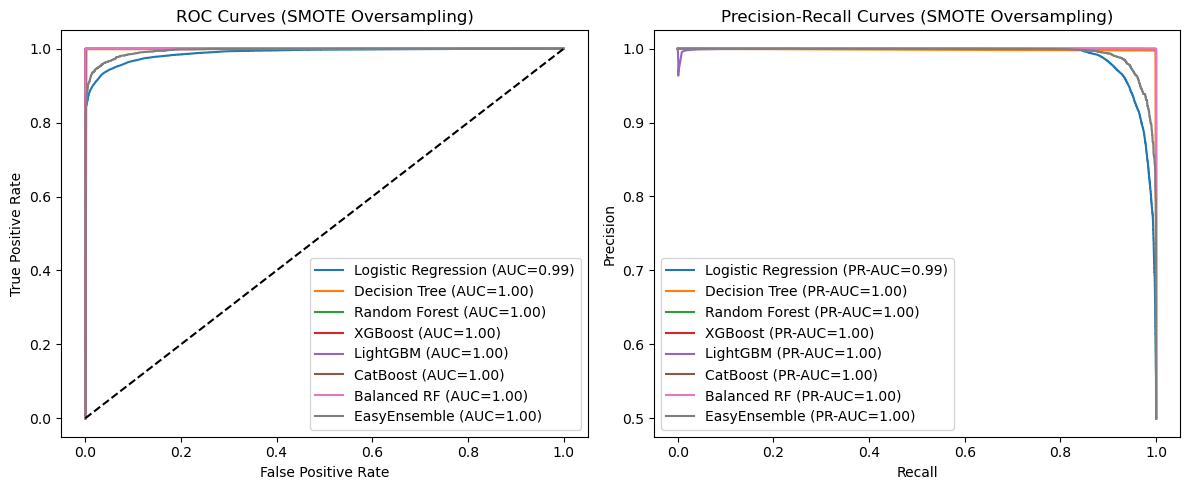


Final Results (SMOTE Oversampling):
                  Model   Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  94.532868   0.972801  0.916205  0.943655  0.988692
1        Decision Tree  99.822850   0.997585  0.998873  0.998229  0.998229
2        Random Forest  99.991824   0.999836  1.000000  0.999918  1.000000
3              XGBoost  99.967295   0.999346  1.000000  0.999673  0.999997
4             LightGBM  99.910971   0.998348  0.999873  0.999110  0.999847
5             CatBoost  99.948218   0.998965  1.000000  0.999482  0.999988
6          Balanced RF  99.992732   0.999855  1.000000  0.999927  1.000000
7         EasyEnsemble  96.131764   0.973518  0.948385  0.960787  0.995040


In [126]:
# ===========================
# 2. Oversampling (SMOTE)
# ===========================
X = data.drop('Class', axis=1)
y = data['Class']
X_res, y_res = SMOTE().fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

results_smote = evaluate_models(X_train, X_test, y_train, y_test, title="SMOTE Oversampling")



In [128]:

# ===========================
# Hyperparameter Tuning (Random Forest on SMOTE data)
# ===========================
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist,
                            n_iter=5, scoring='roc_auc', cv=3, random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
print("Best RF Params (SMOTE):", search.best_params_)

Best RF Params (SMOTE): {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': None}


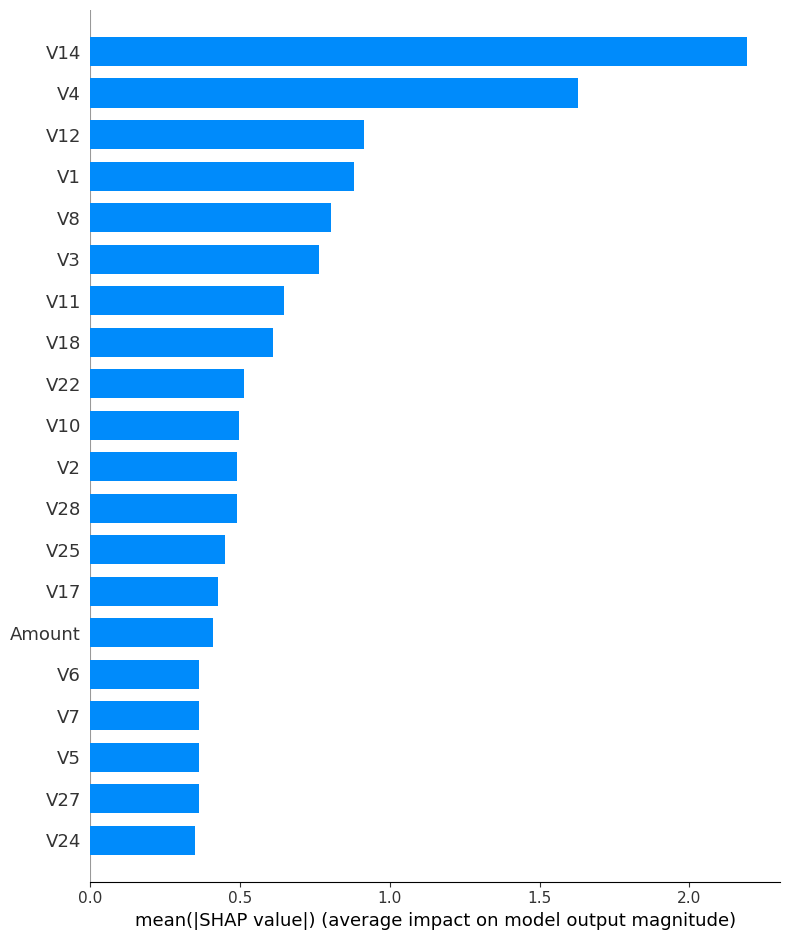

In [129]:
# ===========================
# SHAP Interpretability (on XGBoost, SMOTE data)
# ===========================
explainer = shap.TreeExplainer(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train))
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
